# Summary Evaluators

### setup

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Task
Our task here is to analyze the toxictity of random statements, classifying them as Toxic or Not toxic.

Take a look at our dataset!

In [2]:
from langsmith import Client

client = Client()
dataset = client.clone_public_dataset(
    "https://smith.langchain.com/public/89ef0d44-a252-4011-8bb8-6a114afc1522/d"
)

This is a simple toxicity classifier

In [3]:
from openai import OpenAI
openai_client = OpenAI()
from pydantic import BaseModel, Field

class Toxicity(BaseModel):
    toxicity: str = Field(description="""'Toxic' if this the statement is toxic, 'Not toxic' if the statement is not toxic.""")

def good_classifier(inputs: dict) -> dict:
    completion = openai_client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": f"This is the statement: {inputs['statement']}"
            }
        ],
        response_format=Toxicity,
    )

    toxicity_score = completion.choices[0].message.parsed.toxicity
    return {"class": toxicity_score}

## Summary Evaluators
Summary Evaluator Fields:

Takes lists (not single items):
* inputs: All dataset inputs
* outputs: All target outputs
* reference_outputs: All reference outputs
* runs: All Run objects
* examples: Full dataset Examples with metadata

Metrics like F1-score, precision, recall that need the complete dataset to compute meaningfully. Can't be calculated per-example.

This sort of metric can only be computed over all of the examples in our experiment, so our evaluator takes in a list of outputs, and a list of reference_outputs.

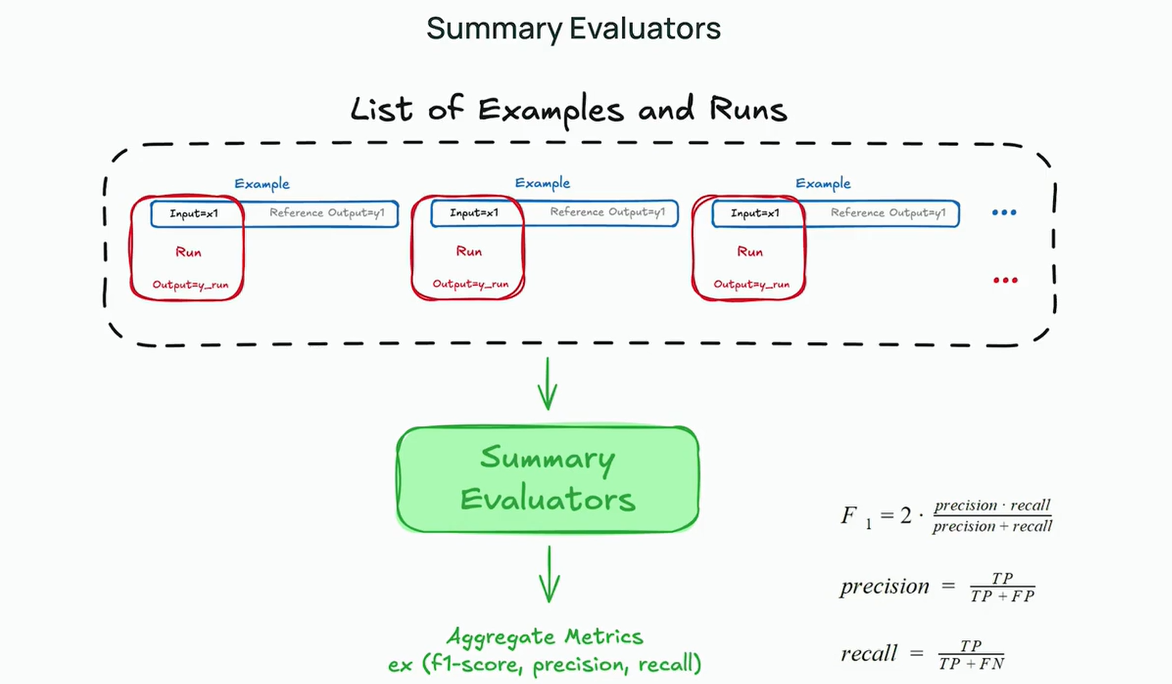

In [4]:
def f1_score_summary_evaluator(outputs: list[dict], reference_outputs: list[dict]) -> dict:
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    for output_dict, reference_output_dict in zip(outputs, reference_outputs):
        output = output_dict["class"]
        reference_output = reference_output_dict["class"]
        if output == "Toxic" and reference_output == "Toxic":
            true_positives += 1
        elif output == "Toxic" and reference_output == "Not toxic":
            false_positives += 1
        elif output == "Not toxic" and reference_output == "Toxic":
            false_negatives += 1

    if true_positives == 0:
        return {"key": "f1_score", "score": 0.0}

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return {"key": "f1_score", "score": f1_score}

Note that we pass in f1_score_summary_evaluator as a summary evaluator!

In [5]:
results = client.evaluate(
    good_classifier,
    data=dataset,
    summary_evaluators=[f1_score_summary_evaluator],
    experiment_prefix="Good classifier"
)

c:\Users\palle\anaconda3\envs\MAT496\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'Good classifier-e2994f66' at:
https://smith.langchain.com/o/90a87341-c5d0-4c68-b120-c011e2a9c3ef/datasets/0662969c-787e-4743-97de-94494380b049/compare?selectedSessions=3e682f55-637a-45f6-aa0e-14bba2493329




9it [03:48, 25.40s/it]


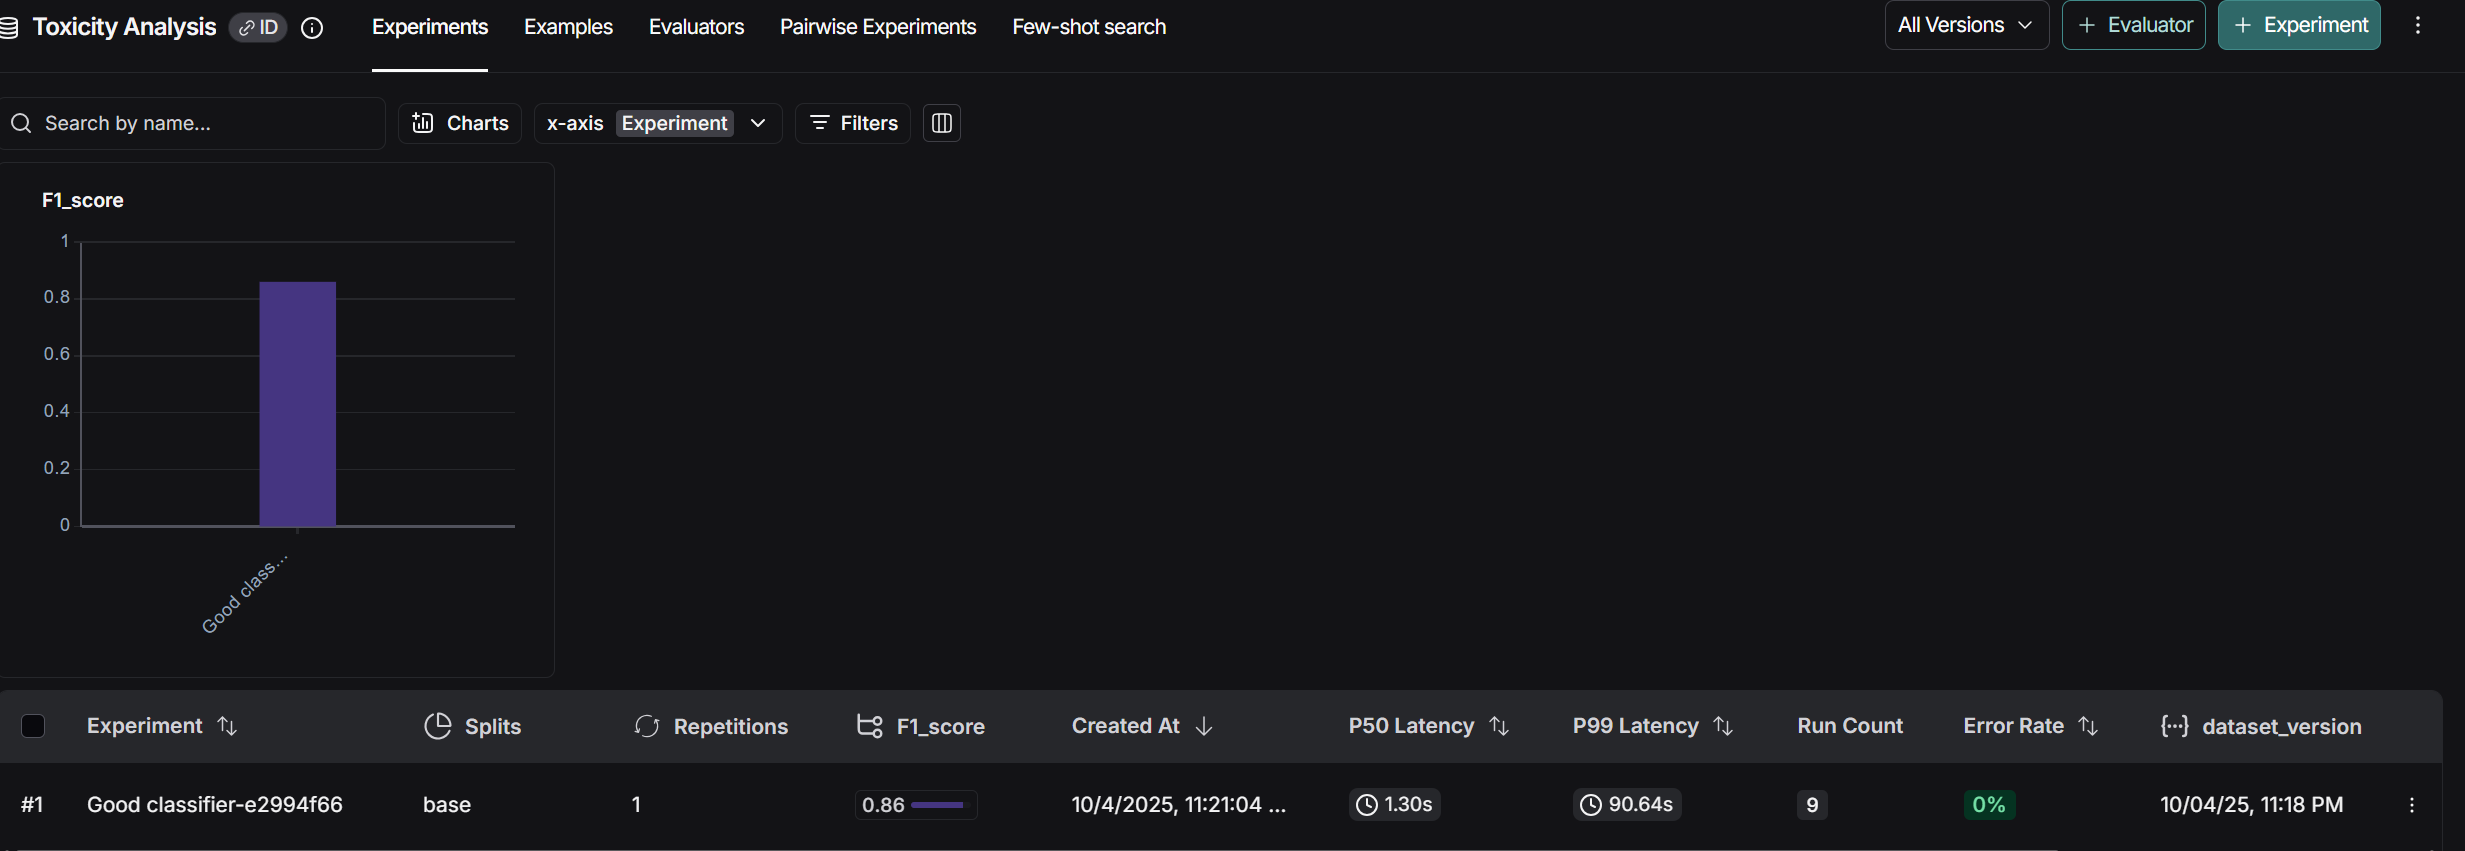